In [1]:
!pip install torchdata
!pip install -U torchtext==0.13.0
!pip install datasets
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached torch-1.12.1-cp38-cp38-manylinux1_x86_64.whl (776.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.12.0
    Uninstalling torch-1.12.0:
      Successfully uninstalled torch-1.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.13.0 requires torch==1.12.0, but you have torch 1.12.1 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached torch-1.12.0-cp38-cp38-manylinux1_x86_64.whl (776.3 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1
    Uninstalling torch-1.12.1:
      Successfully uninstalled torch-1.1

In [2]:
import torch
import torchtext
import datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [180]:
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))
print(stops)

{'him', 'than', 'itself', 're', 'mightn', "you'll", 'and', 'hadn', "you'd", 'if', 'as', 'into', 'under', "won't", 'don', 'an', "mightn't", 'isn', 'hers', 'she', "wouldn't", 'doing', 'me', 'yours', 'herself', 'where', 'down', 'their', 'from', 'all', 'had', 'are', 'y', "haven't", 'same', 'most', 'be', 'myself', 'off', 'not', 'them', 'when', 'we', 'other', 'its', 'over', 's', 'below', 'yourself', 't', 'haven', "hadn't", 'was', 'for', "you're", 'they', "didn't", 'there', 'both', 'i', 'what', 'these', 'of', 'up', 'few', 'out', 'on', 'needn', 'doesn', 'wouldn', 'themselves', 'being', 'because', 'once', 'been', 'won', 'again', 'some', 'weren', 'own', 'it', "shan't", 'didn', 'very', 'any', 'this', 'ourselves', 'now', 'so', 'shan', 'in', "wasn't", 'ours', 'theirs', 'each', 'whom', 'further', 'how', 'do', "needn't", 'those', "shouldn't", 'you', 'which', 'more', 'll', 'between', "that'll", 'why', 'that', 'nor', 'have', 'his', "you've", 'the', 'above', "isn't", 'm', 'just', 'aren', 'shouldn', 'aft

In [181]:
# get dataset from hugging face library
train_data, test_data = datasets.load_dataset('imdb', split = ['train', 'test'])

Reusing dataset imdb (/home/ec2-user/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/2 [00:00<?, ?it/s]

In [182]:
# reshuffle training and test datasets (randomize)
train_data = train_data.shuffle()
test_data = test_data.shuffle()

In [183]:
train_data[:10]

{'text': ['Panic delivers the goods ten fold with Oscar caliber performances from William H Macy, Neve Campbell, and Donald Sutherland. In a movie about the choices we make and the consequences we live with. Chillingly Honest and thought provoking, Panic is easily one of the best film to come out of Hollywood in years. The impact stays with you right after you leave the theater.',
  "IMDb lists this as 1972 for some reason, but the other sources I've seen including the excellent program notes mark it as '68. Doesn't really matter, except that it's quite interesting to watch this abstract collage of film and video (one of the first art works to merge the two apparently) in the context of the Star Gate sequence in 2001, released the same year. Pure abstraction isn't really my thing, but I can take it in small doses and the super-saturated optically printed colors and psychedelic feel of this series of flowers, Rohrschach blots, birds, etc is pretty compelling and quite beautiful. Certain

In [184]:
# FOR TESTING PURPOSES ONLY
train_data = train_data[:3000]
train_data = datasets.Dataset.from_dict(train_data)

In [185]:
from torchtext.data.utils import get_tokenizer

# use a standard english tokenizer
tokenizer = get_tokenizer('basic_english')

In [186]:
# function that tokenizes the data and removes stopwords
def tokenize_data(ex):
    stop_words = set(stopwords.words('english'))
    tokens = tokenizer(ex['text'])
    tokens_without_stopwords = [token for token in tokens if token not in stop_words]
    return {'tokens': tokens_without_stopwords}

In [187]:
train_data = train_data.map(tokenize_data)
test_data = test_data.map(tokenize_data)

  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [188]:
train_data, test_data

(Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 3000
 }),
 Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 25000
 }))

In [189]:
#Documentation: https://huggingface.co/docs/datasets/v2.4.0/en/package_reference/main_classes#datasets.Dataset.train_test_split
# split the training data into training and validation data
train_valid_data = train_data.train_test_split() # default test_size is 0.25
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

In [190]:
train_data, valid_data, test_data

(Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 2250
 }),
 Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 750
 }),
 Dataset({
     features: ['text', 'label', 'tokens'],
     num_rows: 25000
 }))

In [191]:
from torchtext.vocab import Vocab, build_vocab_from_iterator

UNK_IDX, PAD_IDX = 0, 1
special_symbols = ['<unk>', '<pad>']

# build vocab from the text tokens from training data
vocab = build_vocab_from_iterator(train_data['tokens'], min_freq = 100, specials = special_symbols)
#vocab = build_vocab_from_iterator(train_data['tokens'], max_tokens = 32, specials = special_symbols)

# set unknown index as the default
vocab.set_default_index(UNK_IDX)

In [192]:
len(vocab)

419

In [143]:
vocab.get_itos()[:30]

['<unk>',
 '<pad>',
 '.',
 ',',
 "'",
 'movie',
 'film',
 ')',
 '(',
 'one',
 '!',
 'like',
 '?',
 'good',
 'would',
 'even',
 'story',
 'time',
 'see',
 'really',
 'much',
 '-',
 'well',
 'people',
 'bad',
 'also',
 'great',
 'get',
 'way',
 'first']

In [193]:
# transform the tokens into numerical values 
def transform_tokens_idxs(ex):
  idxs = {'idxs': [vocab[token] for token in ex['tokens']]}
  return idxs

In [194]:
# add a column with the idxs
train_data = train_data.map(transform_tokens_idxs)
valid_data = valid_data.map(transform_tokens_idxs)
test_data = test_data.map(transform_tokens_idxs)

  0%|          | 0/2250 [00:00<?, ?ex/s]

  0%|          | 0/750 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [195]:
train_data, valid_data, test_data

(Dataset({
     features: ['text', 'label', 'tokens', 'idxs'],
     num_rows: 2250
 }),
 Dataset({
     features: ['text', 'label', 'tokens', 'idxs'],
     num_rows: 750
 }),
 Dataset({
     features: ['text', 'label', 'tokens', 'idxs'],
     num_rows: 25000
 }))

In [196]:
# SIMPLE RNN MODEL
from torch import nn

class RNN(nn.Module):
# I referred to this tutorial for help: https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/1%20-%20Simple%20Sentiment%20Analysis.ipynb
    def __init__(self, vocab_size, emb_dim, hid_dim, output_dim):
        super().__init__()
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        # RNN layer
        self.rnn = nn.RNN(emb_dim, hid_dim) # default batch_first is False
        # linear layer
        self.linear = nn.Linear(hid_dim, output_dim)
    def forward(self, text):
        # input text is dimension [seq_len, batch_size]
        # apply embeddings to the words
        embedded = self.embedding(text)
        # embedded is dimension [seq_len, batch_size, emb_dim] because batch_first = False
        # run through RNN
        output, hidden = self.rnn(embedded)
        # hidden is dimension [1, batch_size, hid_dim]
        # get the predictions
        scores = self.linear(hidden.squeeze(0))
        # scores should have the dimension [batch_size, output_dim]
        return scores

In [197]:
from torch.nn.utils.rnn import pad_sequence

# collate function to put examples in batches 
def collate_batch(batch):
  batch_idxs, batch_labels = [], []

  for b in batch: 
    #print(b)
    batch_idxs.append(torch.LongTensor(b['idxs']))
    batch_labels.append(torch.tensor(b['label']))

  # pad idxs that are shorter than the longest sentence
  batch_idxs = pad_sequence(batch_idxs, batch_first = False, padding_value = PAD_IDX)
  batch_labels = torch.stack(batch_labels)

  batch = {'idxs': batch_idxs,
           'labels': batch_labels}
  
  return batch

In [198]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

criterion = nn.CrossEntropyLoss()

In [199]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

RNN(
  (embedding): Embedding(419, 128)
  (rnn): RNN(128, 256)
  (linear): Linear(in_features=256, out_features=2, bias=True)
)

In [200]:
from torch.utils.data import DataLoader

BATCH_SIZE = 500

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_batch)

In [201]:
import torch.optim as optim

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-3)

In [202]:
def get_accuracy(predictions, actual_labels):
    batch_size = predictions.shape[0]
    predicted_labels = predictions.argmax(1)
    num_correct = (predicted_labels == actual_labels).sum()
    accuracy = num_correct / batch_size
    return accuracy

In [203]:
def train(dataloader, model, optimizer):
    model.train()

    epoch_loss, epoch_accuracy = 0, 0

    for idx, batch in enumerate(dataloader):
        token_ids = batch['idxs']
        labels = batch['labels']
        optimizer.zero_grad()
        predictions = model(token_ids)
        loss = criterion(predictions, labels)
        accuracy = get_accuracy(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_accuracy += accuracy.item()
    # model.layer
    return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [205]:
def evaluate(dataloader, model):
    model.eval()

    epoch_loss, epoch_accuracy = 0, 0

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            token_ids = batch['idxs']
            labels = batch['labels']
            predictions = model(token_ids)
            loss = criterion(predictions, labels)
            accuracy = get_accuracy(predictions, labels)
            epoch_loss += loss.item()
            epoch_accuracy += accuracy.item()

    return epoch_loss / len(dataloader), epoch_accuracy / len(dataloader)

In [206]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Epoch: 01 | Time: 1m 4s
train_loss: 3.526, train_acc: 0.495
valid_loss: 0.955, valid_acc: 0.500
test_loss: 0.923, test_acc: 0.494
Epoch: 02 | Time: 0m 58s
train_loss: 0.952, train_acc: 0.502
valid_loss: 0.743, valid_acc: 0.500
test_loss: 0.734, test_acc: 0.494
Epoch: 03 | Time: 1m 3s
train_loss: 0.740, train_acc: 0.502
valid_loss: 0.785, valid_acc: 0.500
test_loss: 0.781, test_acc: 0.494
Epoch: 04 | Time: 1m 5s
train_loss: 0.903, train_acc: 0.501
valid_loss: 1.601, valid_acc: 0.504
test_loss: 1.733, test_acc: 0.504
Epoch: 05 | Time: 0m 58s
train_loss: 1.563, train_acc: 0.493
valid_loss: 1.097, valid_acc: 0.505
test_loss: 1.112, test_acc: 0.504
Epoch: 06 | Time: 1m 2s
train_loss: 2.468, train_acc: 0.496
valid_loss: 1.936, valid_acc: 0.497
test_loss: 1.678, test_acc: 0.502
Epoch: 07 | Time: 1m 2s
train_loss: 1.874, train_acc: 0.500
valid_loss: 0.936, valid_acc: 0.499
test_loss: 0.935, test_acc: 0.500
Epoch: 08 | Time: 0m 57s
train_loss: 0.761, train_acc: 0.492
valid_loss: 0.695, valid_ac

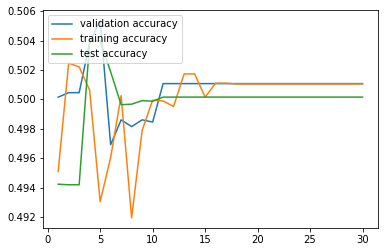

In [33]:
# RNN (with vocab min freq = 100 and batch size = 500 and lr=0.1)
N_EPOCHS = 30
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader)
    valid_loss, valid_acc = evaluate(valid_dataloader)
    test_loss, test_acc = evaluate(test_dataloader)

    end_time = time.time()

    valid_accuracies.append(valid_acc)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
    print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")

Epoch: 01 | Time: 0m 0s
train_loss: 17.970, train_acc: 0.000
valid_loss: 0.000, valid_acc: 1.000
Epoch: 02 | Time: 0m 0s
train_loss: 0.000, train_acc: 1.000
valid_loss: 0.000, valid_acc: 1.000
Epoch: 03 | Time: 0m 0s
train_loss: 0.000, train_acc: 1.000
valid_loss: 0.000, valid_acc: 1.000
Epoch: 04 | Time: 0m 0s
train_loss: 0.000, train_acc: 1.000
valid_loss: 0.000, valid_acc: 1.000
Epoch: 05 | Time: 0m 0s
train_loss: 0.000, train_acc: 1.000
valid_loss: 0.000, valid_acc: 1.000
Epoch: 06 | Time: 0m 0s
train_loss: 0.000, train_acc: 1.000
valid_loss: 0.000, valid_acc: 1.000
Epoch: 07 | Time: 0m 0s
train_loss: 0.000, train_acc: 1.000
valid_loss: 0.000, valid_acc: 1.000
Epoch: 08 | Time: 0m 0s
train_loss: 0.000, train_acc: 1.000
valid_loss: 0.000, valid_acc: 1.000
Epoch: 09 | Time: 0m 0s
train_loss: 0.000, train_acc: 1.000
valid_loss: 0.000, valid_acc: 1.000
Epoch: 10 | Time: 0m 0s
train_loss: 0.000, train_acc: 1.000
valid_loss: 0.000, valid_acc: 1.000
Epoch: 11 | Time: 0m 0s
train_loss: 0.0

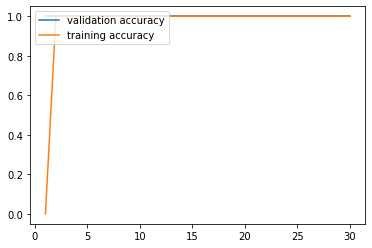

In [67]:
# RNN (with vocab min freq = 2 and batch size = 1 and lr=0.1 and only 3 examples)
# lr of 1e-3 is a better learning rate
N_EPOCHS = 30
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader)
    valid_loss, valid_acc = evaluate(valid_dataloader)
    #test_loss, test_acc = evaluate(test_dataloader)

    end_time = time.time()

    valid_accuracies.append(valid_acc)
    train_accuracies.append(train_acc)
    #test_accuracies.append(test_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
    #print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
#plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")

Epoch: 01 | Time: 0m 6s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.509
Epoch: 02 | Time: 0m 6s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.509
Epoch: 03 | Time: 0m 6s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.509
Epoch: 04 | Time: 0m 6s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.509
Epoch: 05 | Time: 0m 6s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.509
Epoch: 06 | Time: 0m 6s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.509
Epoch: 07 | Time: 0m 6s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.509
Epoch: 08 | Time: 0m 6s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.509
Epoch: 09 | Time: 0m 6s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.509
Epoch: 10 | Time: 0m 7s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.509
Epoch: 11 | Time: 0m 7s
train_loss: 0.69

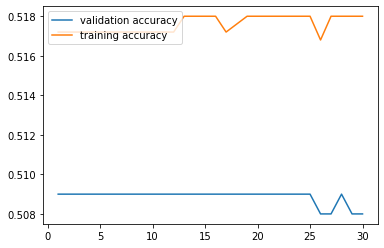

In [157]:
# RNN (with vocab min freq = 100 and batch size = 500 and lr=1e-3 and only 3000 examples)
# lr of 1e-3 is a better learning rate
N_EPOCHS = 30
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader)
    valid_loss, valid_acc = evaluate(valid_dataloader)
    #test_loss, test_acc = evaluate(test_dataloader)

    end_time = time.time()

    valid_accuracies.append(valid_acc)
    train_accuracies.append(train_acc)
    #test_accuracies.append(test_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
    #print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
#plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")

Epoch: 01 | Time: 0m 10s
train_loss: 0.693, train_acc: 0.508
valid_loss: 0.693, valid_acc: 0.509
Epoch: 02 | Time: 0m 17s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.509
Epoch: 03 | Time: 0m 14s
train_loss: 0.702, train_acc: 0.503
valid_loss: 0.698, valid_acc: 0.532
Epoch: 04 | Time: 0m 4s
train_loss: 0.721, train_acc: 0.531
valid_loss: 0.709, valid_acc: 0.509
Epoch: 05 | Time: 0m 3s
train_loss: 0.687, train_acc: 0.551
valid_loss: 0.762, valid_acc: 0.508
Epoch: 06 | Time: 0m 4s
train_loss: 0.732, train_acc: 0.500
valid_loss: 0.692, valid_acc: 0.526
Epoch: 07 | Time: 0m 4s
train_loss: 0.700, train_acc: 0.544
valid_loss: 0.763, valid_acc: 0.509
Epoch: 08 | Time: 0m 4s
train_loss: 0.717, train_acc: 0.542
valid_loss: 0.715, valid_acc: 0.509
Epoch: 09 | Time: 0m 11s
train_loss: 0.709, train_acc: 0.481
valid_loss: 0.700, valid_acc: 0.510
Epoch: 10 | Time: 0m 12s
train_loss: 0.715, train_acc: 0.517
valid_loss: 0.693, valid_acc: 0.513
Epoch: 11 | Time: 0m 14s
train_loss

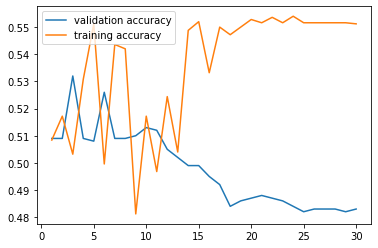

In [168]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 128
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

criterion = nn.CrossEntropyLoss()

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# RNN (with vocab min freq = 100 and batch size = 500 and lr=5e-3 and only 3000 examples)
N_EPOCHS = 30
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader, model, optimizer)
    valid_loss, valid_acc = evaluate(valid_dataloader, model)
    #test_loss, test_acc = evaluate(test_dataloader)

    end_time = time.time()

    valid_accuracies.append(valid_acc)
    train_accuracies.append(train_acc)
    #test_accuracies.append(test_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
    #print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
#plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")

Epoch: 01 | Time: 0m 11s
train_loss: 0.693, train_acc: 0.517
valid_loss: 0.713, valid_acc: 0.446
Epoch: 02 | Time: 0m 4s
train_loss: 0.702, train_acc: 0.496
valid_loss: 0.735, valid_acc: 0.505
Epoch: 03 | Time: 0m 8s
train_loss: 0.704, train_acc: 0.515
valid_loss: 0.940, valid_acc: 0.496
Epoch: 04 | Time: 0m 6s
train_loss: 0.777, train_acc: 0.503
valid_loss: 0.784, valid_acc: 0.507
Epoch: 05 | Time: 0m 6s
train_loss: 0.745, train_acc: 0.485
valid_loss: 0.695, valid_acc: 0.499
Epoch: 06 | Time: 0m 5s
train_loss: 0.698, train_acc: 0.510
valid_loss: 0.719, valid_acc: 0.498
Epoch: 07 | Time: 0m 5s
train_loss: 0.705, train_acc: 0.513
valid_loss: 0.695, valid_acc: 0.505
Epoch: 08 | Time: 0m 5s
train_loss: 0.699, train_acc: 0.486
valid_loss: 0.697, valid_acc: 0.499
Epoch: 09 | Time: 0m 5s
train_loss: 0.695, train_acc: 0.485
valid_loss: 0.697, valid_acc: 0.501
Epoch: 10 | Time: 0m 5s
train_loss: 0.696, train_acc: 0.515
valid_loss: 0.693, valid_acc: 0.499
Epoch: 11 | Time: 0m 5s
train_loss: 0.6

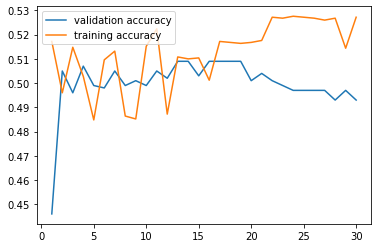

In [173]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 50
HIDDEN_DIM = 128
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

criterion = nn.CrossEntropyLoss()

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# RNN (with vocab min freq = 100 and batch size = 500 and lr=5e-3 and only 3000 examples)
N_EPOCHS = 30
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader, model, optimizer)
    valid_loss, valid_acc = evaluate(valid_dataloader, model)
    #test_loss, test_acc = evaluate(test_dataloader)

    end_time = time.time()

    valid_accuracies.append(valid_acc)
    train_accuracies.append(train_acc)
    #test_accuracies.append(test_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
    #print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
#plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")

In [178]:
sum(p.nelement() for p in model.parameters())

44598

In [ ]:
model.linear.weight.grad.norm().item() # gets the gradients
# after every iterations, save this to a list to see if the gradient norms are varying too much

In [179]:
model

RNN(
  (embedding): Embedding(426, 50)
  (rnn): RNN(50, 128)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)

In [ ]:
# increase embedding dim and hidden dim 128 and 256 respectively

Epoch: 01 | Time: 0m 16s
train_loss: 0.716, train_acc: 0.484
valid_loss: 0.768, valid_acc: 0.489
Epoch: 02 | Time: 0m 14s
train_loss: 0.716, train_acc: 0.529
valid_loss: 0.854, valid_acc: 0.532
Epoch: 03 | Time: 0m 19s
train_loss: 0.796, train_acc: 0.475
valid_loss: 0.691, valid_acc: 0.532
Epoch: 04 | Time: 0m 19s
train_loss: 0.741, train_acc: 0.553
valid_loss: 0.697, valid_acc: 0.482
Epoch: 05 | Time: 0m 20s
train_loss: 0.700, train_acc: 0.502
valid_loss: 0.733, valid_acc: 0.511
Epoch: 06 | Time: 0m 21s
train_loss: 0.724, train_acc: 0.499
valid_loss: 0.706, valid_acc: 0.487
Epoch: 07 | Time: 0m 22s
train_loss: 0.691, train_acc: 0.518
valid_loss: 0.714, valid_acc: 0.516
Epoch: 08 | Time: 0m 22s
train_loss: 0.705, train_acc: 0.479
valid_loss: 0.695, valid_acc: 0.480
Epoch: 09 | Time: 0m 25s
train_loss: 0.694, train_acc: 0.552
valid_loss: 0.695, valid_acc: 0.518
Epoch: 10 | Time: 0m 24s
train_loss: 0.692, train_acc: 0.523
valid_loss: 0.695, valid_acc: 0.518
Epoch: 11 | Time: 0m 26s
train

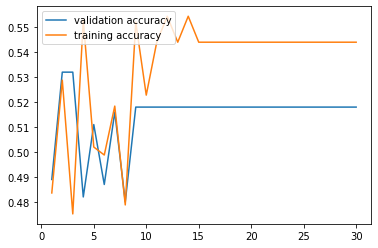

In [207]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

criterion = nn.CrossEntropyLoss()

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# RNN (with vocab min freq = 100 and batch size = 500 and lr=5e-3 and only 3000 examples)
N_EPOCHS = 30
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader, model, optimizer)
    valid_loss, valid_acc = evaluate(valid_dataloader, model)
    #test_loss, test_acc = evaluate(test_dataloader)

    end_time = time.time()

    valid_accuracies.append(valid_acc)
    train_accuracies.append(train_acc)
    #test_accuracies.append(test_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
    #print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
#plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")

Epoch: 01 | Time: 0m 16s
train_loss: 0.693, train_acc: 0.511
valid_loss: 0.694, valid_acc: 0.480
Epoch: 02 | Time: 0m 16s
train_loss: 0.693, train_acc: 0.511
valid_loss: 0.694, valid_acc: 0.480
Epoch: 03 | Time: 0m 16s
train_loss: 0.693, train_acc: 0.511
valid_loss: 0.694, valid_acc: 0.480
Epoch: 04 | Time: 0m 16s
train_loss: 0.693, train_acc: 0.511
valid_loss: 0.694, valid_acc: 0.480
Epoch: 05 | Time: 0m 16s
train_loss: 0.693, train_acc: 0.511
valid_loss: 0.694, valid_acc: 0.480
Epoch: 06 | Time: 0m 16s
train_loss: 0.693, train_acc: 0.511
valid_loss: 0.694, valid_acc: 0.480
Epoch: 07 | Time: 0m 18s
train_loss: 0.693, train_acc: 0.511
valid_loss: 0.694, valid_acc: 0.480
Epoch: 08 | Time: 0m 17s
train_loss: 0.693, train_acc: 0.511
valid_loss: 0.694, valid_acc: 0.480
Epoch: 09 | Time: 0m 16s
train_loss: 0.693, train_acc: 0.511
valid_loss: 0.694, valid_acc: 0.480
Epoch: 10 | Time: 0m 17s
train_loss: 0.693, train_acc: 0.511
valid_loss: 0.694, valid_acc: 0.480
Epoch: 11 | Time: 0m 17s
train

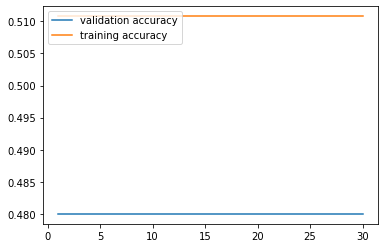

In [208]:
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 2 # there are only 2 labels - 0 (neg) or 1 (pos)

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

criterion = nn.CrossEntropyLoss()

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean=0, std=0.01)
        
model.apply(init_weights)

# initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-6)

# RNN (with vocab min freq = 100 and batch size = 500 and lr=5e-3 and only 3000 examples)
N_EPOCHS = 30
best_valid_loss = float('inf')

valid_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(N_EPOCHS):
  
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader, model, optimizer)
    valid_loss, valid_acc = evaluate(valid_dataloader, model)
    #test_loss, test_acc = evaluate(test_dataloader)

    end_time = time.time()

    valid_accuracies.append(valid_acc)
    train_accuracies.append(train_acc)
    #test_accuracies.append(test_acc)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}')
    print(f'valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}')
    #print(f'test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}')

plt.plot(range(1, N_EPOCHS+1), valid_accuracies, label = 'validation accuracy')
plt.plot(range(1, N_EPOCHS+1), train_accuracies, label = 'training accuracy')
#plt.plot(range(1, N_EPOCHS+1), test_accuracies, label = 'test accuracy')
plt.legend(loc="upper left")